In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


%matplotlib inline

In [2]:
api_url = "https://voice-api.dapt.tech"
api_url_stage = "https://staging-voice-api.dapt.tech"
ml_api = "http://52.86.72.117:5000/features"
ml_api_compare = "http://52.86.72.117:5000/compare"

In [3]:
user_ids = [18, 19, 20, 21, 22, 23, 36, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 56, 57, 58, 61, 62, 64, 66, 68, 69, 70, 71, 72, 78, 79, 80, 82, 83, 84, 85, 86]  # new one started from 36; 80(?); 45 wrong read # another new from 
user_ids_stage = [10, 23, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38]

In [4]:
# get admin tokens
username = ''  # put username here
password = ''  # put password here

params = {
    "username": username,
    'password': password
}

r = requests.post(f'{api_url}/api/v1/auth/login/', json=params)
token = r.json().get('access')

r = requests.post(f'{api_url_stage}/api/v1/auth/login/', json=params)
token_stage = r.json().get('access')

In [5]:
headers = {"Authorization": f"Bearer {token}"}
headers_stage = {"Authorization": f"Bearer {token_stage}"}

In [6]:
# get user info

users = []

def get_user_info(user_id, api_url, headers):
    user_info_url = f"{api_url}/api/v1/user/{user_id}"
    r = requests.get(user_info_url, headers=headers)
    res = r.json()
    audio_samples = res.get("audio_samples")
    imprint = list(cdict['file'] for cdict in audio_samples if cdict["sample_type"] == "1")[0]
    checkin = list(cdict['file'] for cdict in audio_samples if cdict["sample_type"] == "2")[0]
    checkout = list(cdict['file'] for cdict in audio_samples if cdict["sample_type"] == "3")[0]
    user_info = {
        'id': r.json().get('id'),
        'imprint': imprint,
        'checkin': checkin,
        'checkout': checkout
    }
    return user_info

# get from prod
two_users = [18, 19]
for user_id in tqdm(two_users): 
    user_info = get_user_info(user_id, api_url, headers)
    users.append(user_info)
    # print(f'got {user_id}')

100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


In [7]:
# get features

users_features = []

def get_features(api_url, file_url, mean_on=False):
    params = {
        "url": file_url,
        'mean': mean_on
    }
    r = requests.get(api_url, params=params)
    res = r.json()
    features = res['features']
    return features

for user in tqdm(users):
    try:
        user_id = user['id']
        # print(f'User {user_id}')
        imprint = get_features(ml_api, user['imprint'], mean_on=True)
        # print(' got imprint')
        checkin = get_features(ml_api, user['checkin'])
        # print(' got checkin')
        checkout = get_features(ml_api, user['checkout'])
        # print(' got checkout')
        user_features = {
            'id': user['id'],
            'imprint': imprint,
            'checkin': checkin,
            'checkout': checkout
        }
        users_features.append(user_features)
    except Exception as e:
        pass
        # print(' got exception!!!')
    # print('\n')

100%|██████████| 2/2 [00:25<00:00, 12.53s/it]


In [8]:
# get efatures to experiment with
features = users_features[0]['imprint']
d_vector = features['d_vector']

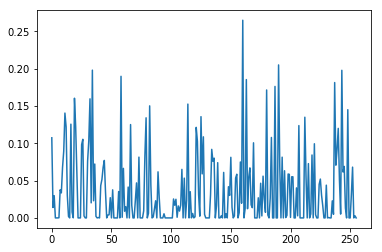

In [9]:
# plot d_vector
fig, ax = plt.subplots()
ax.plot(d_vector)

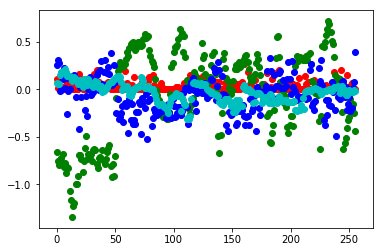

In [10]:
# plot all features
default_len = 256
len_range = list(range(0, default_len))
colors = {'d_vector': 'r', 'lfcc': 'g', 'mfcc': 'b', 'pncc': 'c'}
fig, ax = plt.subplots()
for feature in features:
    ax.scatter(len_range, features[feature][:256], color=colors[feature])

In [11]:
# normalize features
d_vec = np.array(features['d_vector'])
mfcc_vec = (np.array(features['mfcc'][:256])+1)/2
lfcc_vec = (np.array(features['lfcc'][:256])+1)/2
pncc_vec = (np.array(features['pncc'][:256])+1)/2

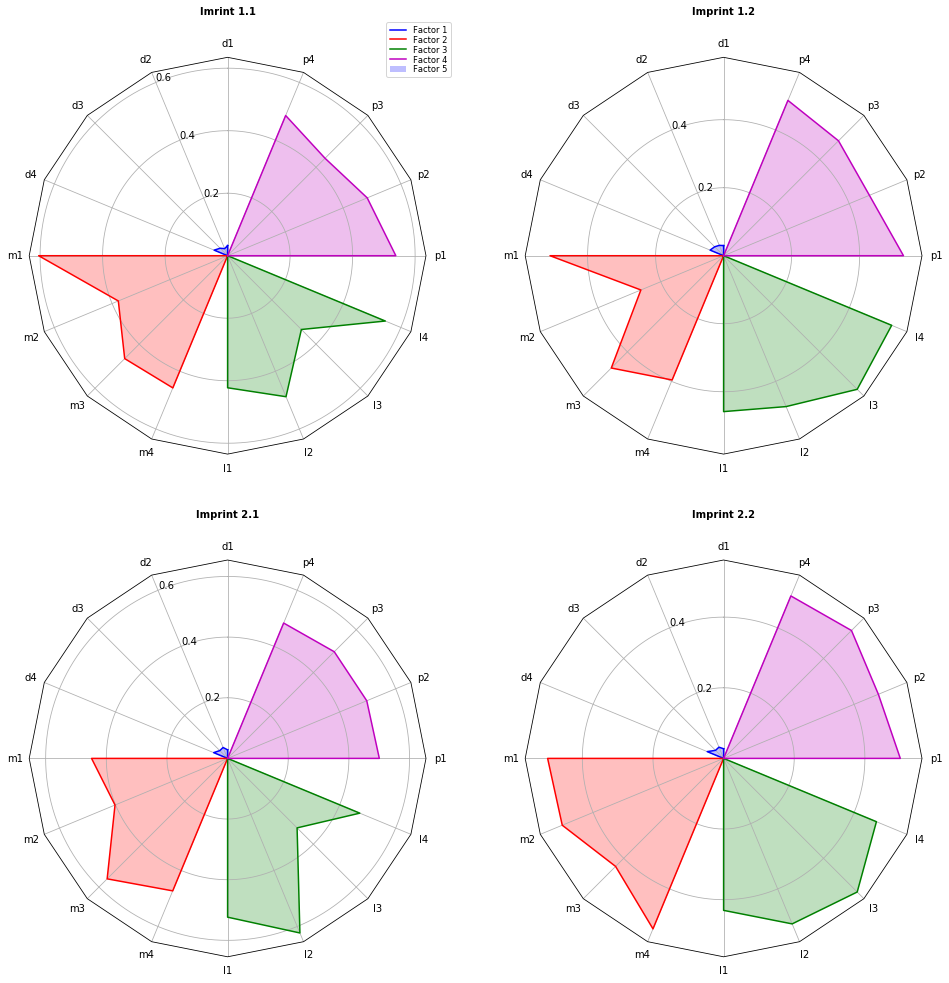

In [12]:
# plot radar for four sets of features

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    data = [['d1', 'd2', 'd3', 'd4', 'm1', 'm2', 'm3', 'm4', 'l1', 'l2', 'l3', 'l4', 'p1', 'p2', 'p3', 'p4'],
            ("Imrint 1.1", [
                [0.03237987, 0.02449125, 0.03373247, 0.04666355  , 0,0,0,0, 0,0,0,0, 0,0,0,0],
                [0,0,0,0, .60456661,0.37844138, 0.46563479, 0.45784632, 0,0,0,0, 0,0,0,0],
                [0,0,0,0, 0,0,0,0, 0.4225569 , 0.48833868,0.33383639, 0.54618501, 0,0,0,0],
                [0,0,0,0, 0,0,0,0, 0,0,0,0, 0.53823178, 0.48352073, 0.44087378,0.48547175]]),
            ("Imprint 1.2", [
                [0.02974155, 0.03291668, 0.03712278, 0.04304615  , 0,0,0,0, 0,0,0,0, 0,0,0,0],
                [0,0,0,0, 0.51048959, 0.26331675, 0.46706281, 0.39559086, 0,0,0,0, 0,0,0,0],
                [0,0,0,0, 0,0,0,0, 0.4584825 , 0.48024022, 0.55565519, 0.53500255, 0,0,0,0],
                [0,0,0,0, 0,0,0,0, 0,0,0,0, 0.52897895, 0.46411144, 0.47784272,0.49435656]]),
            ("Imprint 2.1", [
                [0.02831673, 0.03886179, 0.03636739, 0.04967929, 0,0,0,0, 0,0,0,0, 0,0,0,0],
                [0,0,0,0, 0.44860755, 0.40184917, 0.5616929 , 0.47282003, 0,0,0,0, 0,0,0,0], 
                [0,0,0,0, 0,0,0,0, 0.52354534, 0.62308175, 0.32406933, 0.47180711, 0,0,0,0],
                [0,0,0,0, 0,0,0,0, 0,0,0,0, 0.50033618, 0.49668605, 0.49741358, 0.48309063]]),
            ("Imprint 2.2", [
                [0.0273349 , 0.03436653, 0.03230113, 0.05021021, 0,0,0,0, 0,0,0,0, 0,0,0,0],
                [0,0,0,0, 0.49825509, 0.49445269, 0.43251599, 0.5224285, 0,0,0,0, 0,0,0,0,],
                [0,0,0,0, 0,0,0,0, 0.43026043, 0.50717649, 0.53499969, 0.46835722, 0,0,0,0],
                [0,0,0,0, 0,0,0,0, 0,0,0,0, 0.5002988 , 0.47433103, 0.51207606, 0.49783418]])
           ]
            
    return data


if __name__ == '__main__':
    N = 16
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(16, 16), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm']  # , 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = axs[0, 0].legend(labels, loc=(0.9, .95),
                              labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

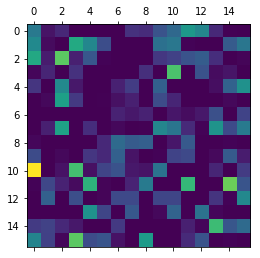

In [13]:
# plot d_vector as heatmap
data = d_vec.reshape((16,16))
plt.matshow(data)
plt.show()

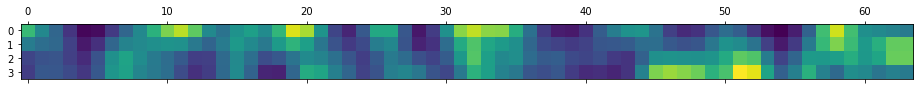

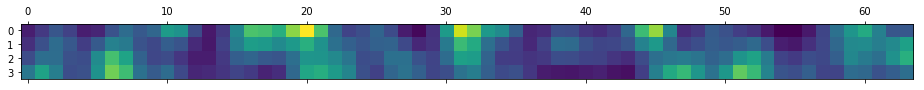

In [14]:
# plot augmented heatmap of d_vector for two users
for user_features in users_features:
    d_vector = user_features['imprint']['d_vector'][:256]
    d_vector = np.array(d_vector)
    
#     d_vector = savgol_filter(d_vector, 51, 3)
#     d_reshaped = d_vector.reshape((16, 16))
#     d_smoothed = gaussian_filter(d_reshaped, sigma=[1.5, 1.5])
    
    d_reshaped = d_vector.reshape((4, 64))
    
    d_smoothed = gaussian_filter(d_reshaped, sigma=[1, 1])
    
    data = d_smoothed
    plt.matshow(data)
    plt.show()

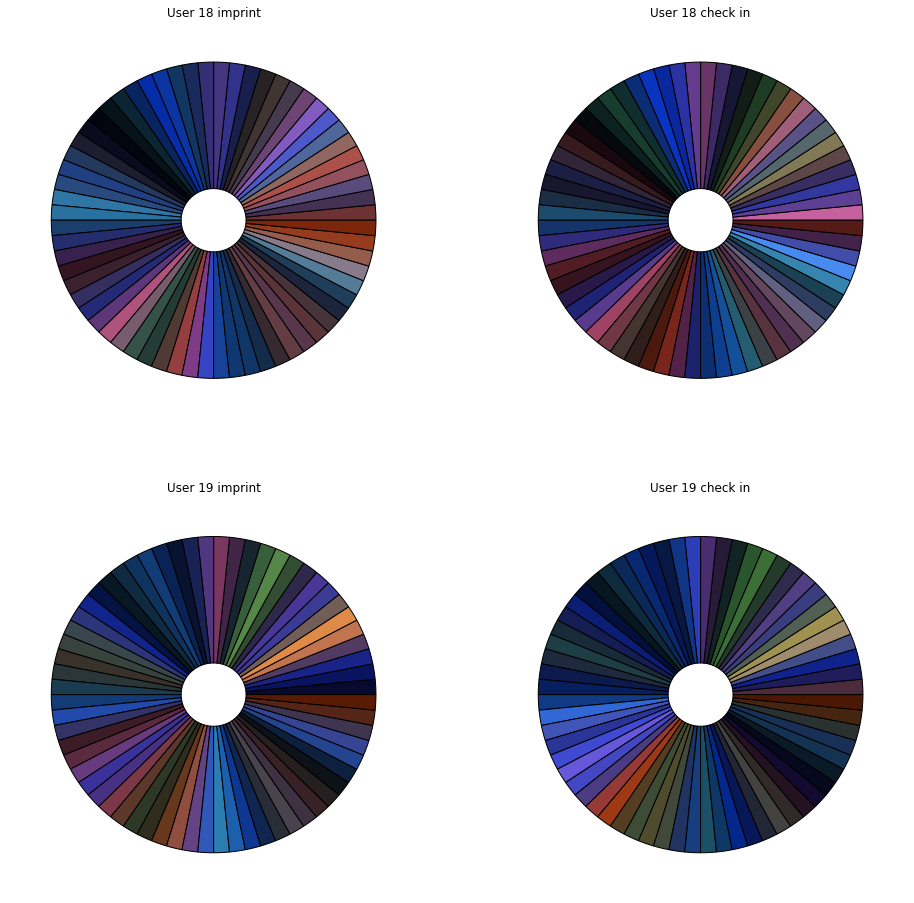

In [15]:
# plot "vinyl" for two users

fig, axs = plt.subplots(figsize=(16, 16), nrows=2, ncols=2)

names = [f"User {two_users[0]} imprint", f"User {two_users[0]} check in", f"User {two_users[1]} imprint", f"User {two_users[1]} check in"]

def get_features_to_show(inp_features):
    features = np.array(inp_features)
    
    features_reshaped = features.reshape((64, 4))
    features_smoothed = gaussian_filter(features_reshaped, sigma=[0.9, 0.7])
    
    return features_smoothed
    

i = 0

features_to_show = [
    users_features[0]['imprint'],
    users_features[0]['checkin'],
    users_features[1]['imprint'],
    users_features[1]['checkin']
]

for ax, user_features in zip(axs.flat, features_to_show):
    
    d_vector = user_features['d_vector']
    features_smoothed = get_features_to_show(d_vector)
    
    data = [1 for x in range(64)] 
    colors = [(min(x[0]*7, 1), min(x[1]*7,1), min(x[2]*10,1)) for x in features_smoothed]
    
    ax.set_title(names[i])
    ax.pie(data, colors=colors, wedgeprops=dict(width=0.8, edgecolor='black'))
    
    i += 1

plt.show() 